**Phase 1: Understand the data (Mounting drive, loading files, initial EDA)**

In [2]:
# 0. Mount Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 1. Imports
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import OrdinalEncoder

In [4]:
# 2. Unzip dataset
zip_path = '/content/drive/MyDrive/Copy of datasheet.zip'
extract_to = '/content/data'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

base_path = '/content/data/bluebook-for-bulldozers'
trainvalid = pd.read_csv(f'{base_path}/TrainAndValid.csv', low_memory=False)
test = pd.read_csv(f'{base_path}/Test.csv', low_memory=False)
sales_ids = test['SalesID'].copy()

Train shape: (412698, 53)
Missing values summary:
Pushblock            386715
Tip_Control          386715
Enclosure_Type       386715
Engine_Horsepower    386715
Blade_Extension      386715
Blade_Width          386715
Scarifier            386704
Grouser_Tracks       367823
Hydraulics_Flow      367823
Coupler_System       367724
dtype: int64


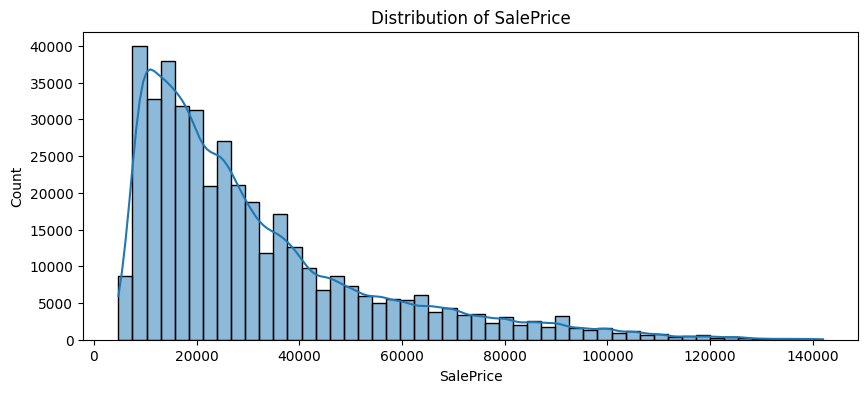

In [5]:
# 3. EDA Summary
print("Train shape:", trainvalid.shape)
print("Missing values summary:")
print(trainvalid.isnull().sum().sort_values(ascending=False).head(10))

plt.figure(figsize=(10,4))
sns.histplot(trainvalid['SalePrice'], bins=50, kde=True)
plt.title("Distribution of SalePrice")
plt.show()

**Phase 2: Data Cleaning (Adding relevant features, dropping columns, handling missing values, encoding)**

In [6]:
# 4. Add date features
def add_date_features(df):
    df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce')
    df['saleYear'] = df['saledate'].dt.year
    df['saleMonth'] = df['saledate'].dt.month
    df['machine_age'] = df['saleYear'] - df['YearMade']
    return df

trainvalid = add_date_features(trainvalid)
test = add_date_features(test)

In [7]:
# 5. Drop unnecessary columns
drop_cols = ['SalesID', 'MachineID', 'ModelID', 'saledate',
             'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
             'fiModelSeries', 'fiModelDescriptor']
trainvalid.drop(columns=drop_cols, inplace=True, errors='ignore')
test.drop(columns=drop_cols, inplace=True, errors='ignore')


In [8]:
# 6. Handle missing values
cat_cols = trainvalid.select_dtypes(include='object').columns.tolist()
num_cols = trainvalid.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = [col for col in cat_cols if col != 'SalePrice']

for col in cat_cols:
    trainvalid[col] = trainvalid[col].fillna("Missing")
    test[col] = test[col].fillna("Missing")

for col in num_cols:
    med = trainvalid[col].median()
    trainvalid[col] = trainvalid[col].fillna(med)
    if col in test.columns:
        test[col] = test[col].fillna(med)

In [9]:
# 7. Encode categoricals
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
trainvalid[cat_cols] = encoder.fit_transform(trainvalid[cat_cols].astype(str))
test[cat_cols] = encoder.transform(test[cat_cols].astype(str))

**Phase 3: Model Building (train/val split, trying different models, evaluating model performance)**

In [10]:
# 8. Prepare split
X = trainvalid.drop('SalePrice', axis=1)
y = np.log1p(trainvalid['SalePrice'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# 9. Try multiple models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=42),
    "Ridge": Ridge(alpha=1.0),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

actual_vals = np.expm1(y_val)
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = np.expm1(model.predict(X_val))
    rmsle_score = np.sqrt(mean_squared_log_error(actual_vals, preds))
    print(f"{name} RMSLE: {rmsle_score:.4f}")

Random Forest RMSLE: 0.2629
Ridge RMSLE: 0.5171
Decision Tree RMSLE: 0.3586
Gradient Boosting RMSLE: 0.3360


In [12]:
# 10. Final model on full data (Random Forest)
rf_final = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=42)
rf_final.fit(X, y)


RandomForestRegressor(max_features='sqrt', random_state=42)

**Phase 4: Making Predictions (Feature importances, final model on test data)**

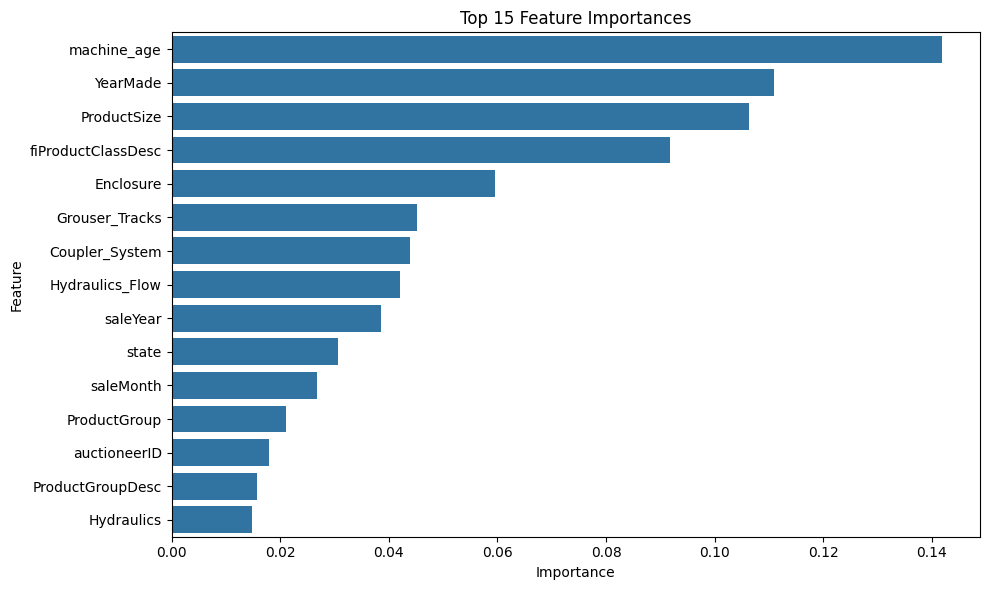

In [13]:
# 11. Feature importances
importances = rf_final.feature_importances_
features = X.columns
fi_df = pd.DataFrame({'Feature': features, 'Importance': importances})
fi_df = fi_df.sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=fi_df)
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()


In [14]:
# 12. Predict on test
test_preds = np.expm1(rf_final.predict(test))

In [15]:
# 13. Export
test_predictions = pd.DataFrame({"SalesID": sales_ids, "SalePrice": test_preds})
test_predictions.to_csv("test_predictions.csv", index=False)
print("\n Submission file saved as: test_predictions.csv")


 Submission file saved as: test_predictions.csv
